<a href="https://colab.research.google.com/github/pedrohqr/feeling_analyser/blob/main/trab01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing packages

In [ ]:
!pip install -U sentence-transformers
!pip install --upgrade gspread
!pip install -U scikit-learn
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 4.9 MB 34.9 MB/s 
     |████████████████████████████████| 1.3 MB 48.9 MB/s 
     |████████████████████████████████| 163 kB 58.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6c72392bc2295a3fe4fee22adbe3d09003d393afdc268681355a884ceee97733
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2
Looking in indexes: https://p

#Import libraries and Sheet

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt

creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('twitter_candidatos').sheet1 #open twitter_candidatos.gsheet in my GoogleDrive

In [ ]:
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
df=pd.DataFrame(rows[1:],columns=rows[0]) #copy the 2th row position ahead, cause the 1th position is the column name

In [ ]:
df['comentario'].values.tolist()

['Viva Jair Bolsonaro.O melhor presidente da história desse país.O tamanho do choro da esquerda, é o tamanho do sucesso do evento. https://t.co/W2H4IewwMs',
 '@ducavendish Esse fracasso.',
 '@Kgsteiner @fredericodbs PM se prestando a capanga do bolsonaro. Que várzea.',
 'rainha elizabeth o bolsonaro de calcinha',
 '@BolsonaroSP BOLSONARO VTNC!!',
 '@mlauju23 @PedroRonchi2 Bolsonaro tem foto com Arthur Lira, Roberto Jeferson, Valdemar Costa Neto e mais uma nata…Lula continua ganhando KKKKK',
 'Quer festa melhor e presente maior do que o Presidente Bolsonaro reeleito e ter a chance de eleger em 2026 seu vice ou quem por ele indicado para sucedê-lo?',
 'O erro dele é claro ,mas a punição e desproporcional! Gostaria de ver está disposição pra prender o lula e seus iguais ladrões,subir o morro e prender e levar pro presidio os grandes traficante . Este cara já tem a esposa que dará ele pagar caro por está merda que fez. https://t.co/gswNRwD5t0',
 '@JDCensurada @alexandrecases Ela é tão pé d

Separating all comments positives, negatives and neutral, in respectively order

# Split test-training

In [ ]:
pos = []
neg = []
neu = []
for sent in df.values.tolist():
  if sent[0] == 'pos':
    pos += [sent[2]]
  elif sent[0] == 'neg':
    neg += [sent[2]]
  else:
    neu += [sent[2]]

xtrain_global = pos+neg+neu
ytrain_global = ['pos']*len(pos)+['neg']*len(neg)+['neu']*len(neu)

In [ ]:
xtrain_global,ytrain_global

Separate tests, training and validation

In [ ]:
#Split data set in 80% for training and 20% for test
xtrain, xtest, ytrain, ytest = train_test_split(xtrain_global, ytrain_global, test_size=0.20, random_state=42,shuffle=True)

In [ ]:
print('Dataset size: ',len(xtrain_global))
print('Training size: ', len(xtrain))
print('Test size: ', len(xtest))

Dataset size:  800
Training size:  640
Test size:  160


Convert the dataset in Sentence BERT

In [ ]:
model = SentenceTransformer('multi-qa-distilbert-cos-v1')

In [ ]:
xtrain_emb = model.encode(xtrain)
xtest_emb = model.encode(xtest)

# KNN - Cross Validation

Training with KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(xtrain_emb,ytrain)

KNeighborsClassifier(n_neighbors=27)

Find better K for KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 80)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(xtrain_emb,ytrain)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 27}

In [ ]:
cv_scores = cross_val_score(knn, xtrain_emb, ytrain, cv=5)

Generating data info(Confusion Matrix, Classification Report and Accuracy)

In [ ]:
pred = knn.predict(xtest_emb)
print('Confusion Matrix: ')
print(confusion_matrix(ytest, pred))
print('')
print('Classification report: ')
print(classification_report(ytest,pred))
print('Accuracy: ', (accuracy_score(ytest, pred))*100,'%')

Confusion Matrix: 
[[ 3 22  7]
 [ 1 69  9]
 [ 2 16 31]]

Classification report: 
              precision    recall  f1-score   support

         neg       0.50      0.09      0.16        32
         neu       0.64      0.87      0.74        79
         pos       0.66      0.63      0.65        49

    accuracy                           0.64       160
   macro avg       0.60      0.53      0.52       160
weighted avg       0.62      0.64      0.60       160

Accuracy:  64.375 %


# Final model

In [ ]:
dump(knn, 'candidatos.joblib')

['candidatos.joblib']

In [ ]:
final_model = load('candidatos.joblib')

In [ ]:
final_model.predict([model.encode('bolsonazi')])[0]

'neg'

# Scanning Twitter
Using snscrape API, I collect some tweets about the 4 Brazilians president candidates and store it in different arrays

In [ ]:
from collections import OrderedDict
import snscrape.modules.twitter as sns

#Scanning_Twitter()

def Scanning_Twitter():
  query_bolsonaro = "(bolsonaro OR bolsonazi OR bolsomito OR bolsonabo OR broxonaro OR bolsolixo) lang:pt"
  query_lula = "(lula OR luiz inacio OR luladrao OR lulindo) lang:pt"
  query_ciro = "(ciro OR ciro gomes OR cirao OR cirao da massa) lang:pt"
  query_simone = "(simone tebet OR tebet) lang:pt"

  max_size = 200 #max size of each query

  content_bolsonaro = []
  content_lula      = []
  content_ciro      = []
  content_simone    = []

  #final_model.predict([model.encode(tweet.content)])
  #query bolsonaro
  for tweet in sns.TwitterSearchScraper(query_bolsonaro).get_items():
      content_bolsonaro.append([final_model.predict(model.encode([tweet.content]))[0], tweet.date, tweet.content])
      if len(content_bolsonaro) > max_size:
          break
      

  #query lula
  for tweet in sns.TwitterSearchScraper(query_lula).get_items():
      content_lula.append([final_model.predict(model.encode([tweet.content]))[0], tweet.date, tweet.content])
      if len(content_lula) > max_size:
          break

  #query ciro
  for tweet in sns.TwitterSearchScraper(query_ciro).get_items():
      content_ciro.append([final_model.predict(model.encode([tweet.content]))[0], tweet.date, tweet.content])
      if len(content_ciro) > max_size:
          break

  #query simone
  for tweet in sns.TwitterSearchScraper(query_simone).get_items():
      content_simone.append([final_model.predict(model.encode([tweet.content]))[0], tweet.date, tweet.content])
      if len(content_simone) > max_size:
          break
  return content_bolsonaro, content_lula, content_ciro, content_simone

In [ ]:
#content_bolsonaro

Count pos, neg, neu for each candidate

In [ ]:
def Count_Tweet(content_bolsonaro, content_lula, content_ciro, content_simone):
  #[nº positive, nº negative, nº neutral]
  val_bolsonaro = [0, 0, 0]
  val_lula = [0, 0, 0]
  val_simone = [0, 0, 0]
  val_ciro = [0, 0, 0]

  #count pos and neg from Jair Bolsonaro
  for content in content_bolsonaro:
    if content[0] == 'pos':
      val_bolsonaro[0] += 1
    elif content[0] == 'neg':
      val_bolsonaro[1] += 1
    else: #neu
      val_bolsonaro[2] += 1

  #count pos and neg from Lula
  for content in content_lula:
    if content[0] == 'pos':
      val_lula[0] += 1
    elif content[0] == 'neg':
      val_lula[1] += 1
    else: #neu
      val_lula[2] += 1

  #count pos and neg from Ciro Gomes
  for content in content_ciro:
    if content[0] == 'pos':
      val_ciro[0] += 1
    elif content[0] == 'neg':
      val_ciro[1] += 1
    else: #neu
      val_ciro[2] += 1

  #count pos and neg from Simone Tebet
  for content in content_simone:
    if content[0] == 'pos':
      val_simone[0] += 1
    elif content[0] == 'neg':
      val_simone[1] += 1
    else: #neu
      val_simone[2] += 1
  return val_bolsonaro, val_lula, val_ciro, val_simone

#Building chart
After I collect the values of Twitter comments, then built a chart with total of comments and their classification about each candidate

In [ ]:
def Build_Chart(pos, neg, neu):
  # set width of bar
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8))
  
  # Set position of bar on X axis
  br1 = np.arange(len(pos))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
  
  # Make the plot
  plt.bar(br1, pos, color ='g', width = barWidth,
          edgecolor ='grey', label ='Positivo')
  plt.bar(br2, neg, color ='r', width = barWidth,
          edgecolor ='grey', label ='Negativo')
  plt.bar(br3, neu, color ='gray', width = barWidth,
          edgecolor ='grey', label ='Neutro')
  
  # Adding Xticks
  plt.xlabel('Candidatos à Presidência', fontweight ='bold', fontsize = 15)
  plt.ylabel('Nº de comentários', fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(pos))],
          ['Bolsonaro', 'Lula', 'Ciro Gomes', 'Simone Tebet'])
  plt.title('Reputação dos candidatos à Presidência no Twitter', fontweight ='bold', fontsize = 20)
  plt.grid()
    
  plt.legend()
  plt.show()

# Run application within n seconds

Mon, 03 Oct 2022 02:19:19


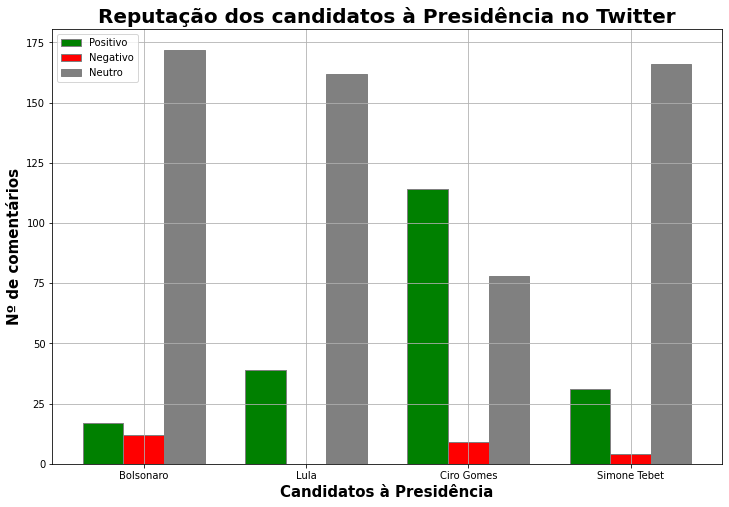

KeyboardInterrupt: ignored

In [ ]:
import time
from time import gmtime, strftime

while True: #loop
  print(strftime('%a, %d %b %Y %H:%M:%S', gmtime())) #show time info
  ctc_bolsonaro, ctc_lula, ctc_ciro, ctc_simone = Scanning_Twitter() #scanning comments on Twitter
  vl_bolsonaro, vl_lula, vl_ciro, vl_simone = Count_Tweet(ctc_bolsonaro, ctc_lula, ctc_ciro, ctc_simone) #split pos, neg and neu for each candidate
  Build_Chart([vl_bolsonaro[0], vl_lula[0], vl_ciro[0], vl_simone[0]], #sum of pos of all candidates
              [vl_bolsonaro[1], vl_lula[1], vl_ciro[1], vl_simone[1]], #sum of neg of all candidates
              [vl_bolsonaro[2], vl_lula[2], vl_ciro[2], vl_simone[2]]) #sum of neu of all candidates
  #building the chart
  time.sleep(15*60) #wait for the next 15 min